In [1]:
# Install dependency
!pip install --upgrade --user --quiet furiosa-sdk[runtime] pillow matplotlib

In [2]:
from PIL import ImageDraw
from PIL import Image

# Import necessary modules
from furiosa.runtime import session
from helper import load_labels, image_path, show_image
from helper.mobilenet_ssd import *

libnpu.so --- v2.0, built @ 2b26367


# SSD Object Detection

In [3]:
%%time
# Load and compile a ssd model for Furiosa'a NPU
ssd_detection = session.create('models/mscoco_300x300_ssd_mobilenet_v1_uint8_quantization-aware-trained.tflite')

[1/6] 🔍   Compiling from tflite to dfg
Done in 0.3112012s
[2/6] 🔍   Compiling from dfg to ldfg
Done in 215.20418s
[3/6] 🔍   Compiling from ldfg to cdfg
Done in 0.000465234s
[4/6] 🔍   Compiling from cdfg to gir
Done in 0.020016523s
[5/6] 🔍   Compiling from gir to lir
Done in 0.003570104s
[6/6] 🔍   Compiling from lir to enf
Done in 0.07824274s
✨  Finished in 215.61859s


Oct 10 22:14:01.357  INFO Npu (npu3pe0-1) is being initialized
Oct 10 22:14:01.357  INFO NuxInner create with pes: [PeId(0)]
Oct 10 22:14:01.451  INFO [Profiler] Program binary notification has been arrived. Cleanup current profile queue data
CPU times: user 3min 35s, sys: 310 ms, total: 3min 36s
Wall time: 3min 36s


In [4]:
ssd_detection.print_summary()

Inputs:
{0: TensorDesc: shape=(1, 300, 300, 3), dtype=uint8, format=NHWC, size=270000, len=270000}
Outputs:
{0: TensorDesc: shape=(1, 50, 4), dtype=float32, format=???, size=800, len=200, 1: TensorDesc: shape=(1, 50), dtype=float32, format=??, size=200, len=50, 2: TensorDesc: shape=(1, 50), dtype=float32, format=??, size=200, len=50, 3: TensorDesc: shape=(1,), dtype=float32, format=?, size=4, len=1}


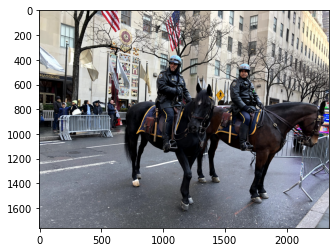

In [5]:
# Load an image

image = Image.open(image_path('street.jpg')).convert('RGB')
show_image(image)

In [6]:
# Resize the image with pads to fit in the model input shape

w_scale, h_scale, data = get_padded_image(ssd_detection, image)

In [7]:
# Let's make sure that the shape of the data is matched to the that of the model input.

print(ssd_detection.input(0).shape())
print(data.shape)

(1, 300, 300, 3)
(1, 300, 300, 3)


In [8]:
%%time
# Run a prediction task
outputs = ssd_detection.run(data)

CPU times: user 145 ms, sys: 20 ms, total: 165 ms
Wall time: 172 ms


In [9]:
# This model has 4 output tensors. Please refer to the description of output tensors at 
# https://www.tensorflow.org/lite/models/object_detection/overview
len(outputs)

4

### Postprocessing

Let's draw:
1. the rectangles with labels according to the locations, 
1. classification IDs
1. scores from the output tensors

You can learn more about the details about output tensors from https://www.tensorflow.org/lite/models/object_detection/overview#output_signature

person: 98% (box: 1542, 415, 1807, 1143)
horse: 96% (box: 709, 559, 1479, 1578)
horse: 94% (box: 1201, 645, 2295, 1578)
person: 87% (box: 898, 300, 1203, 1167)
person: 72% (box: 427, 726, 491, 851)
person: 65% (box: 290, 729, 359, 844)
person: 50% (box: 562, 724, 637, 905)


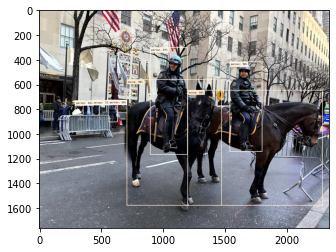

In [10]:
ssd_objects = get_output(ssd_detection, outputs, 0.5, (w_scale, h_scale))
ssd_labels = load_labels('coco_labels.txt')
draw_objects(ImageDraw.Draw(image), ssd_objects, ssd_labels)
show_image(image)
print_objects(ssd_labels, ssd_objects)

In [11]:
ssd_detection.close()

Oct 10 22:14:02.972  INFO [Profiler] Received a termination signal.
Oct 10 22:14:02.972  INFO Profiling summary:
Oct 10 22:14:02.972  INFO [Inference #0-0], [988030958, 1159179276)
Oct 10 22:14:02.972  INFO   ExternalOperator: 155762713 μs, 91.01 %
Oct 10 22:14:02.972  INFO   Io: 13239182 μs, 7.74 %
Oct 10 22:14:02.972  INFO   Total: 171148318 μs
Oct 10 22:14:02.972  INFO 1 inferences executed in 171148318 μs, 0.0 fps
Oct 10 22:14:02.977  INFO session has been destroyed
